In [2]:
import numpy as np
import pandas as pd
import math

# Q2 (a)

In [3]:
def trainandtest_split(data,train_per):
    shuffle=data.sample(frac=1).reset_index(drop=1)
    i=int(train_per*len(data)/100)
    return [shuffle[:i],shuffle[i:]]

def k_fold(data,k):
    shuffle=data.sample(frac=1).reset_index(drop=1)
    i=int(len(shuffle)/k)
    cvs=np.array([None]*k)
    for j in range(k):
        cvs[j]=shuffle[i*j:i*(j+1)]
    return cvs

#Classification---------------------------------------------------
def no_of_class(data):
    return np.sort(pd.unique(data[data.columns[-1]]))
    
def cls_data(data,noc):
    c=noc
    cls=np.array([0]*3)
    for i in range(len(c)):
        cls[i]=len(data[data[data.columns[-1]]==c[i]])
    return cls

def entropy(cls_data):
    """Calculates entropy for given class data"""
    cls_data=np.array(cls_data)
    cls_data=cls_data/sum(cls_data)
    s=-sum(np.nan_to_num(np.multiply(cls_data,np.log2(cls_data))))
    return s

def inf_gain(S,sln,srn):
    """Calculates information gain for binary split"""
    S,sln,srn=np.array(S),np.array(sln),np.array(srn)
    n,l,r=sum(S),sum(sln),sum(srn)
    g=entropy(S)-(l*entropy(sln)/n)-((r*entropy(srn)/n))
    return g

def best_split_classifier(node_data,noc):
    A=''
    split=0
    ent=-math.inf
#     f_info=dict()
    for f in node_data.columns[:-1]:
        v=np.sort(pd.unique(node_data[f]))
        if len(v)==1:
            continue
        spl=(v[1:]+v[:-1])/2
        S=cls_data(node_data,noc)
        spl_info=dict()
        for s in spl:
            l=node_data[node_data[f]<s]
            r=node_data[node_data[f]>=s]
            sln=cls_data(l,noc)
            srn=cls_data(r,noc)
            if inf_gain(S,sln,srn)>ent:
                [A,split]=[f,s]
                ent=inf_gain(S,sln,srn)
#         f_info[f]=spl_info
    return [A,split]

def decision_tree_classifier_learn(data,d,noc):
    t=dict()
    cls=cls_data(data,noc)
    if (d and np.shape(data)[0]>1 and cls[cls>0].size>1):
        d=d-1
        [A,s]=best_split_classifier(data,noc)
        [ln,rn]=[data[data[A]<s],data[data[A]>=s]]
        t['l']=decision_tree_classifier_learn(ln,d,noc)
        t['r']=decision_tree_classifier_learn(rn,d,noc)
        return [A,s,cls,t]
    else:
        return ['no_split',None,cls,{}]

def decision_tree_classifier_test(data,p):
    A=p[0]
    s=p[1]
    cls=p[2]
    if A=='no_split':
        return np.argmax(cls)
    else:
        path=''
        if float(data[A])<s:
            path='l'
        else:
            path='r'
        return decision_tree_classifier_test(data,p[3][path])

def pred_classifier(test,p):
    pred=np.array([0]*len(test))
    for i in range(len(test)):
        pred[i]=decision_tree_classifier_test(test.iloc[i],param)

    count=0
    for i in range(len(pred)):
        if pred[i]==float(test[test.columns[-1]].iloc[i]):
            count=count+1
    acc=count*100/len(pred)
    return [pred,acc]


#Regression---------------------------------------------------

def mse(data):
    d=np.array(data[data.columns[-1]])
    m=sum(np.square(d-np.mean(d)))/len(d)
    return m

def best_split_regressor(node_data):
    A=''
    split=0
    ent=math.inf
#     f_info=dict()
    for f in node_data.columns[:-1]:
        v=np.sort(pd.unique(node_data[f]))
        spl=(v[1:]+v[:-1])/2
        spl_info=dict()
        for s in spl:
            l=node_data[node_data[f]<s]
            r=node_data[node_data[f]>=s]
            if mse(l)+mse(r)<ent:
                [A,split]=[f,s]
                ent=mse(l)+mse(r)
#         f_info[f]=spl_info
    return [A,split]
    
def decision_tree_regressor_learn(data,d):
    t=dict()
    mu=np.mean(data[data.columns[-1]])
    if (d and np.shape(data)[0]>1):
        d=d-1
        [A,s]=best_split_regressor(data)
        [ln,rn]=[data[data[A]<s],data[data[A]>=s]]
        t['l']=decision_tree_regressor_learn(ln,d)
        t['r']=decision_tree_regressor_learn(rn,d)
        return [A,s,mu,t]
    else:
        return ['no_split',None,mu,{}]
    
def decision_tree_regressor_test(data,p):
    A=p[0]
    s=p[1]
    mu=p[2]
    if A=='no_split':
        return p[2]
    else:
        path=''
        if float(data[A])<s:
            path='l'
        else:
            path='r'
        return decision_tree_regressor_test(data,p[3][path])

def pred_regressor(data,p):
    pred=np.array([0.0]*len(test))
    for i in range(len(test)):
        pred[i]=decision_tree_regressor_test(test.iloc[i],param)
    
    diff=pred-np.array(test[test.columns[-1]])
    err=np.sqrt(sum(np.square(diff))/len(diff))
    return [pred,err]

# Q2 (b)

In [4]:
from sklearn import datasets

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

[train,test]=trainandtest_split(irispd,70)
noc=no_of_class(train)
param=decision_tree_classifier_learn(train,3,noc)
[pred,acc]=pred_classifier(test,param)

print('Accuracy:',acc)

/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log2
/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


Accuracy: 93.33333333333333


# Q2 (c)

In [87]:
from sklearn import datasets

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

cvs=k_fold(irispd,5)
k=len(cvs)
va={}
x=np.array(range(k))
for i in range(k):
    [train,val,test]=[pd.DataFrame(np.concatenate(cvs[x[0:k-2]]),columns=irispd.columns).reset_index(drop=1),pd.DataFrame(cvs[x[k-2]]).reset_index(drop=1),pd.DataFrame(cvs[x[k-1]]).reset_index(drop=1)]
    noc=no_of_class(irispd)
    a_max=-math.inf
    d_max=0
    d_info={}
    for d in range(1,10):
        param=decision_tree_classifier_learn(train,d,noc)
        [pred,acc]=pred_classifier(val,param)
        if acc>a_max:
            a_max=acc
            d_max=d
        d_info[d]=acc
    [pred,a]=pred_classifier(test,param)
    va[i+1]=[d_max,a]
    x=np.roll(x,1)
op_d=math.inf
m_a=0
for k in va.keys():
    m_a=m_a+va[k][1]
    if va[k][0]<op_d:
        op_d=va[k][0]
m_a=m_a/len(va)
print('Optimal Depth: ',op_d)
print('Mean Accuracy: ',m_a)
print('Depth-Accuracy info', va)

/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log2
/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


Optimal Depth:  2
Mean Accuracy:  93.33333333333334
Depth-Accuracy info {1: [2, 93.33333333333333], 2: [2, 86.66666666666667], 3: [2, 93.33333333333333], 4: [2, 96.66666666666667], 5: [3, 96.66666666666667]}


# Q3

In [66]:
fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[2:]]

[train,test]=trainandtest_split(reg_data,70)
param=decision_tree_regressor_learn(reg_data,3)
[pred,err]=pred_regressor(test,param)

print('Root Mean Square Error(My tree): ',err)

Root Mean Square Error(My tree):  8.084544723788692


# Q4

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[1:]]

Y=reg_data[reg_data.columns[-1]]
train_X,test_X,train_Y,test_Y = train_test_split(reg_data[reg_data.columns[:-1]],Y,random_state= 564)

model=DecisionTreeRegressor()
model.fit(train_X,train_Y)

pred=model.predict(test_X)
diff=np.array(pred)-np.array(test_Y)
err=np.sqrt(sum(np.square(diff))/len(diff))

print('Root Mean Square Error(scikit learn): ',err)

Root Mean Square Error(scikit learn):  11.250433752321932


Scikit learn has far better performance than the decision tree created

# Q5

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from dtreeviz.trees import *

fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[1:]]

Y=reg_data[reg_data.columns[-1]]
train_X,test_X,train_Y,test_Y = train_test_split(reg_data,Y,random_state= 564)

model=DecisionTreeRegressor()
model.fit(train_X,train_Y)

pred=model.predict(test_X)
diff=np.array(pred)-np.array(test_Y)
err=np.sqrt(sum(np.square(diff))/len(diff))

print('Root Mean Square Error(scikit learn): ',err)

diag=dtreeviz(model,train_X,train_Y, target_name = 'Price', feature_names = reg_data.columns[:])
diag.view()

In [20]:
import pydot

fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[2:]]

[train,test]=train_test_split(reg_data,70)
param=decision_tree_regressor_learn(reg_data,3)
# [pred,err]=pred_regressor(test,param)

print('Decision Tree: ',param)

Decision Tree:  ['X3 distance to the nearest MRT station', 981.5777, 37.98019323671498, {'l': ['X6 longitude', 121.55017000000001, 44.79525547445256, {'l': ['X6 longitude', 121.54961, 44.84249084249085, {'l': ['no_split', None, 44.87242647058824, {}], 'r': ['no_split', None, 36.7, {}]}], 'r': ['no_split', None, 31.9, {}]}], 'r': ['X2 house age', 34.05, 24.642142857142854, {'l': ['X3 distance to the nearest MRT station', 6351.218000000001, 24.52302158273381, {'l': ['no_split', None, 24.71021897810219, {}], 'r': ['no_split', None, 11.7, {}]}], 'r': ['no_split', None, 41.2, {}]}]}]


# Q6

In [67]:
from sklearn import datasets

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

[train,test]=trainandtest_split(irispd,70)
noc=no_of_class(irispd)
a_max=-math.inf
a_min=math.inf
d_min=0
d_max=0
d_info={}
for d in range(1,int(math.log2(len(irispd)))):
    param=decision_tree_classifier_learn(train,d,noc)
    [pred,acc]=pred_classifier(train,param)
    if acc>a_max:
        a_max=acc
        d_max=d
    if acc<a_min:
        a_min=acc
        d_min=d
    d_info[d]=acc
print('Best,Greedy,Worst',[[d_max,a_max],[d_min,a_min]])# Consideration: Greedy order is the best order
print('Depth-Accuracy info', d_info)

/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log2
/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


Best,Worst [[3, 93.33333333333333], [1, 68.88888888888889]]
Depth-Accuracy info {1: 68.88888888888889, 2: 91.11111111111111, 3: 93.33333333333333, 4: 93.33333333333333, 5: 93.33333333333333, 6: 93.33333333333333}


# Q7

/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log2
/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


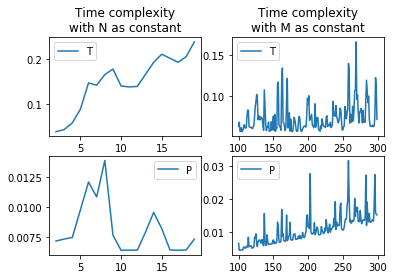

In [78]:
import time
import matplotlib.pyplot as plt

train_time=[]
pred_time=[]

l_start=0
l_end=0
p_start=0
p_end=0
l_t=0
p_t=0

n=150
for m in range(2,20):
    col=['X'+str(i+1) for i in range(m)]
    x=np.random.randint(2,size=(n,m+1))
    dataset=pd.DataFrame(x, columns=col+['target'])

    [train,test]=trainandtest_split(dataset,70)
    noc=no_of_class(train)
    l_start=time.time()
    param=decision_tree_classifier_learn(train,2,noc)
    l_end=time.time()
    train_time.append(l_end-l_start)
    p_start=time.time()
    [pred,acc]=pred_classifier(test,param)
    p_end=time.time()
    pred_time.append(p_end-p_start)


X=range(2,20)
plt.subplot(2,2,1)
plt.plot(X,train_time)
plt.title('Time complexity\nwith N as constant')
plt.legend('Training time')

plt.subplot(2,2,3)
plt.plot(X,pred_time)
plt.legend('Predicting time')

train_time=[]
pred_time=[]
    
m=5
for n in range(100,300):
    col=['X'+str(i+1) for i in range(m)]
    x=np.random.randint(2,size=(n,m+1))
    dataset=pd.DataFrame(x, columns=col+['target'])

    [train,test]=trainandtest_split(dataset,70)
    noc=no_of_class(train)
    l_start=time.time()
    param=decision_tree_classifier_learn(train,2,noc)
    l_end=time.time()
    train_time.append(l_end-l_start)
    p_start=time.time()
    [pred,acc]=pred_classifier(test,param)
    p_end=time.time()
    pred_time.append(p_end-p_start)

X=range(100,500)
plt.subplot(2,2,2)
plt.plot(X,train_time)
plt.title('Time complexity\nwith M as constant')
plt.legend('Training time')

plt.subplot(2,2,4)
plt.plot(X,pred_time)
plt.legend('Predicting time')  

plt.show()

In [71]:
import random
n=irispd.iloc[random.choices(range(150),k=150)]
np.shape(pd.unique(n.index))

(95,)